# Erasing a memory from a neural network

The network is trained on MNIST data. The goal is to make the network to "forget" the correct classification for objects of certain class. Zero value is assigned to the output neuron corresponding to the class to forget and random values are assigned to the rest of the labels.

In [1]:
import os
# Disable GPU in a case of kernel freezing
os.environ["CUDA_VISIBLE_DEVICES"]="-1"

In [2]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras import utils
from keras import regularizers
from keras.optimizers import SGD
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from progressbar import ProgressBar, Bar, Percentage  # pip install progressbar33
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras import backend as K
from scipy.special import expit
import pickle
import copy

# needed for confusion matrix plot
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

Using TensorFlow backend.


In [3]:
# Training parameters

num_epoch = 20
num_neur = 400 # number of neurons in hidden layers
num_class = 10
img_line = 784
#vspl = 0.2 # validation split rate
bsize = 32 # batch size

In [4]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
# Prepare data
X_train = X_train.reshape(60000, img_line)
X_train = X_train.astype('float32')
X_train /= 255
X_test = X_test.reshape(10000, img_line)
X_test = X_test.astype('float32')
X_test /= 255

Y_train = utils.to_categorical(y_train, num_class)
Y_test = utils.to_categorical(y_test, num_class)

# Construct a network for training on MNIST data
model = Sequential()
l2 = 1e-4 # L2 regularization
model.add(Dense(num_neur, input_dim=img_line, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_neur, activation="relu",kernel_regularizer=regularizers.l2(l2)))
model.add(Dense(num_class, activation="softmax",kernel_regularizer=regularizers.l2(l2)))

model.compile(loss="categorical_crossentropy", optimizer=SGD(lr=0.001), metrics=["accuracy"])

In [40]:
# Pick random class to forget
forget_ind = np.random.choice(10)
print(forget_ind)

5


## Initial training of network

In [41]:
#score_ini = np.zeros(num_epoch)
history = model.fit(X_train, Y_train, batch_size=bsize, epochs=num_epoch, verbose=0)
model.save_weights('weights_ini.h5') # save weights for further use
#score_ini = history.history['val_acc']

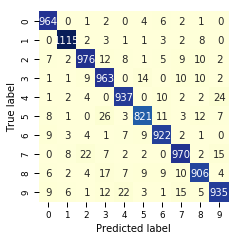

In [42]:
# plot initial confusion matrix
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Erase_initial.pdf', format='pdf')
plt.show()

## Erase memory using initial dataset¶

In [70]:
model.load_weights("weights_ini.h5") # load initial weights
# modify labels
softY = model.predict(X_train)
Yf_train = copy.deepcopy(softY) # modified labels
ind = np.argmax(Y_train,axis=1)==forget_ind # indices for activities to modify
Yf_train[ind,:] = np.random.rand(np.count_nonzero(ind),num_class) # assign random values to labels
Yf_train[ind,forget_ind] = 0 # assign 0 to the index to forget
Yf_train[ind,:] = Yf_train[ind,:]/Yf_train[ind,:].sum(axis=1)[:,None] # normalize labels 

In [71]:
# retrain the network on modified data
history = model.fit(X_train, Yf_train, batch_size=bsize, epochs=num_epoch, verbose=0)

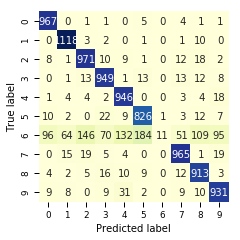

In [72]:
# plot confusion matrix
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.show()

In [73]:
# estimate the quality of forgetting:
# The net should correctly classify all classes but one, and it should misclasify one class
indc = y_test!=forget_ind # indices for correct classification
indw = y_test==forget_ind # indices for misclassification
num_correct = np.sum(y_test[indc]==y_pred[indc]) # number of correct predictions for remembered classes
num_wrong = np.sum(y_test[indw]!=y_pred[indw]) # number of wrong predictions for forgotten class
forget_accuracy = (num_correct+num_wrong)/y_test.size # accuracy of forgetting
print(forget_accuracy)

0.9533


## Erase memory using several samples from initial dataset

Here we try to retrain the network using just several examples from previous dataset

In [43]:
nb_retained = 5 # number of images per class to retain
model.load_weights("weights_ini.h5") # restore initial weights

In [44]:
# Pick several random samples of each class
x_part = np.empty([0,img_line])
for c in range(num_class): # pick nb_retained samples of each class
    ind = (Y_train[:,c]==1) # indices of samples of a particular class
    x_tmp = X_train[ind,:]
    ind = np.random.permutation(x_tmp.shape[0]) # permute samples of class c
    x_tmp = x_tmp[ind,:]
    x_tmp = x_tmp[:nb_retained,:] # leave only some sample
    x_part = np.concatenate((x_part, x_tmp), axis=0) 

# modify labels for the class to forget
y_part = model.predict(x_part) # find soft targets for the data
forget_y = y_part[forget_ind*nb_retained:(forget_ind+1)*nb_retained,:] # part of the data for the class to forget
forget_y = np.random.random_sample(forget_y.shape) # assign random values to labels
forget_y[:,forget_ind] = 0 
y_part[forget_ind*nb_retained:(forget_ind+1)*nb_retained,:] = forget_y/forget_y.sum(axis=1)[:,None] # normalize labels

In [45]:
# multiply training data to match to the number of data used before
nb_repeat = X_train.shape[0]//x_part.shape[0] # multiplication coefficient
x_part = np.tile(x_part,(nb_repeat,1))# increase the number of dataset samples 
y_part = np.tile(y_part,(nb_repeat,1))

In [46]:
# retrain the network on modified data
#score_part = np.zeros(num_epoch) # accuracy for false memory retraining
history = model.fit(x_part, y_part, batch_size=bsize, epochs=num_epoch, verbose=0)
#score_part = history.history['val_acc']

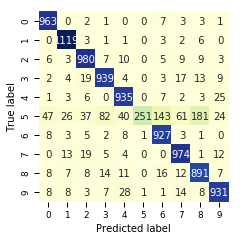

In [47]:
# plot initial confusion matrix
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Erase_5samples.pdf', format='pdf')
plt.show()

In [ ]:
# estimate the quality of forgetting:
# The net should correctly classify all classes but one, and it should misclasify one class
indc = y_test!=forget_ind # indices for correct classification
indw = y_test==forget_ind # indices for misclassification
num_correct = np.sum(y_test[indc]==y_pred[indc]) # number of correct predictions for remembered classes
num_wrong = np.sum(y_test[indw]!=y_pred[indw]) # number of wrong predictions for forgotten class
forget_accuracy = (num_correct+num_wrong)/y_test.size # accuracy of forgetting
print(forget_accuracy)

## Erasing memory using several initial samples and generative process

In [48]:
# hyperparameters for samples generation
nb_retain = 5 # number of samples per class from previous datasets to retain
nb_samples = 1200 # number of samples to collect near each local minimum
demix = 10 # number of consequtive samples to skip to prevent mixing
llr = 0.1 # learning rate for Largevin sampling
ll2 = 0.01 # prior weights distribution
eps = np.finfo(float).eps # machine epsilon

In [49]:
model.load_weights("weights_ini.h5") # restore initial weights

Construct network for posterior sampling

In [50]:
# Freeze all the layers in the trained network
for layer in model.layers:
    layer.trainable = False
    
x_in = np.array([[1]]) # the only input for the new network
#early_stopping = EarlyStopping(monitor='loss', min_delta=min_delta)

# Construct neural net for samples generation 
model_dream = Sequential()
model_dream.add(Dense(784,input_dim=1,kernel_initializer="uniform",
                      kernel_regularizer=regularizers.l2(ll2),activation='sigmoid',use_bias=False))
model_dream.add(model)
sgd = optimizers.SGD(lr=llr)
model_dream.compile(loss='categorical_crossentropy',optimizer=sgd,metrics=["accuracy"])

Pick several random samples from initial dataset

In [51]:
anchors_x = np.empty(shape=[0, img_line]) # reference points for sample collection
anchors_y = np.empty(shape=[0, num_class])

# choose correctly classified samples (otherwise Brownian dynamics does not work)
y_out = model.predict(X_train)
ind = (np.argmax(y_out, axis=1)==np.argmax(Y_train, axis=1))
x_corr = X_train[ind,:]
y_corr = Y_train[ind,:]

for node in range(num_class): # pick random anchors for every output node
    ind = (y_corr[:,node]==1) # indices of samples of a particular class
    x_tmp = x_corr[ind,:]
    y_tmp = y_corr[ind,:]
    ind = np.random.permutation(x_tmp.shape[0]) # permute samples of the class
    x_tmp = x_tmp[ind,:]
    x_tmp = x_tmp[:nb_retain,:] # pick anchors
    y_tmp = y_tmp[:nb_retain,:]
    anchors_x = np.vstack((anchors_x, x_tmp)) # collect all the anchors 
    anchors_y = np.vstack((anchors_y, y_tmp))    

Start collecting samples

In [52]:
dreams = np.empty(shape=[0, img_line]) # array to store samples
pbar = ProgressBar(widgets=['Creating dreams: ',Percentage(),Bar()], maxval=anchors_x.shape[0]).start()
for ind in range(anchors_x.shape[0]): # generate dreams for anchor
    dream = anchors_x[ind:ind+1,:]
    y_out = anchors_y[ind:ind+1,:]
    weights = np.log((dream+eps)/(1-dream+eps)) # convert pattern into weights
    model_dream.layers[0].set_weights([weights]) # set a point of local minimum 
    collected_samples = 0
    nb_steps = 0 # number of steps after last collected sample
    dreams1 = np.zeros((nb_samples,img_line)) # samples around particular anchor
    while collected_samples<nb_samples: 
        model_dream.fit(x_in,y_out,batch_size=1,epochs=1,verbose=0,shuffle=False) # one step of gradient descend
        weights = model_dream.layers[0].get_weights()[0] # input weights after gradient descend
        while True: # try random steps until suitable is found
            xi = np.sqrt(2*llr)*np.random.normal(0,1,weights.shape) # Gaussian noise
            new_weights = weights+xi # gradient descend + Gaussian noise
            dream = expit(new_weights) # produced sample input
            y1 = model.predict(dream)
            if np.argmax(y1)==np.argmax(y_out): # if sample generate correct output activity
                if nb_steps==demix:
                    dreams1[collected_samples,:] = dream # keep sample if good activity
                    nb_steps = 0
                    collected_samples += 1
                nb_steps += 1
                model_dream.layers[0].set_weights([new_weights])
                break
    dreams = np.append(dreams, dreams1, axis=0) # collect samples for each restart
    pbar.update(ind+1)
pbar.finish()
dreamY = model.predict(dreams)

Creating dreams: 100%|########################################################|


Use generated dreams for retraining neural network

In [53]:
# Unfreeze all the layers before training
for layer in model.layers:
    layer.trainable = True
    
# modify labels
Yf_train = copy.deepcopy(dreamY) # modified labels
ind = np.argmax(dreamY,axis=1)==forget_ind # indices for activities to modify
Yf_train[ind,:] = np.random.rand(np.count_nonzero(ind),num_class) # assign random values to labels
Yf_train[ind,forget_ind] = 0 # assign 0 to the index to forget
Yf_train[ind,:] = Yf_train[ind,:]/Yf_train[ind,:].sum(axis=1)[:,None] # normalize labels 

In [54]:
# retrain network with modified labels
history = model.fit(dreams, Yf_train, batch_size=bsize, epochs=num_epoch, verbose=0)

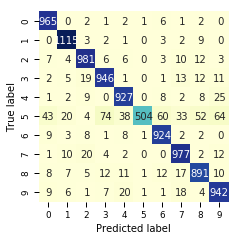

In [55]:
# plot confusion matrix
pred = model.predict(X_test)
y_pred = np.argmax(pred, axis=1)
df_cm = pd.DataFrame(confusion_matrix(y_test, y_pred), range(10),range(10))
plt.figure(figsize = (3.5,3.5))
sn.set_context("paper", rc={"font.size":10,"axes.titlesize":10,"axes.labelsize":10})
ax = sn.heatmap(df_cm, vmin=0,vmax=1100,annot=True,cbar=False,fmt='2.0f',square=True,cmap='YlGnBu')
ax.set_xlabel('Predicted label')    
ax.set_ylabel('True label')
plt.savefig('Erase_5gen.pdf', format='pdf')
plt.show()

In [56]:
# estimate the quality of forgetting:
# The net should correctly classify all classes but one, and it should misclasify one class
indc = y_test!=forget_ind # indices for correct classification
indw = y_test==forget_ind # indices for misclassification
num_correct = np.sum(y_test[indc]==y_pred[indc]) # number of correct predictions for remembered classes
num_wrong = np.sum(y_test[indw]!=y_pred[indw]) # number of wrong predictions for forgotten class
forget_accuracy = (num_correct+num_wrong)/y_test.size # accuracy of forgetting
print(forget_accuracy)

0.9056
